In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import treescope
from IPython.display import display as ipython_display
from penzai import pz

from simplexity.configs.train.config import Config as TrainConfig
from simplexity.configs.train.optimizer.config import AdamConfig
from simplexity.configs.train.optimizer.config import Config as OptimizerConfig
from simplexity.generative_processes.builder import build_hidden_markov_model
from simplexity.persistence.local_persister import LocalPersister
from simplexity.predictive_models.gru_rnn import build_gru_rnn
from simplexity.predictive_models.save_activations import SaveActivations
from simplexity.training.train import train

In [2]:
treescope.basic_interactive_setup(autovisualize_arrays=True)

In [3]:
generative_process = build_hidden_markov_model("mess3", x=0.15, a=0.6)
initial_gen_process_state = generative_process.stationary_state
model = build_gru_rnn(generative_process.vocab_size, num_layers=4, hidden_size=64, seed=0)
persister = LocalPersister(base_dir="/tmp")

cfg = TrainConfig(
    seed=0,
    sequence_len=64,
    batch_size=128,
    num_steps=200,
    log_every=1,
    checkpoint_every=100,
    checkpoint_name="test",
    optimizer=OptimizerConfig(
        name="adam",
        instance=AdamConfig(
            _target_="optax.adam",
            learning_rate=0.001,
            b1=0.9,
            b2=0.999,
            eps=1e-8,
            eps_root=0.0,
            nesterov=True,
        ),
    ),
)

In [4]:
model, losses = train(cfg, model, generative_process, initial_gen_process_state, persister)

[<matplotlib.lines.Line2D at 0x7ff0b02ede50>]

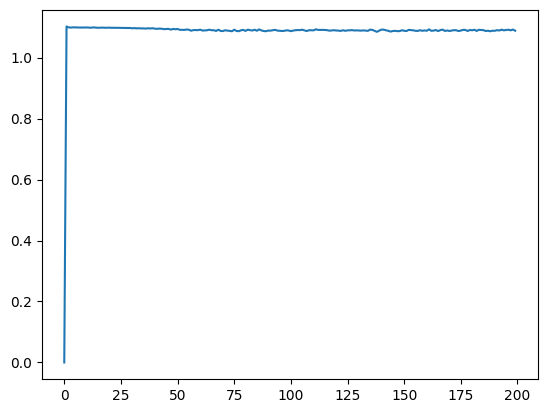

In [5]:
plt.plot(losses)

In [6]:
saved_activations = pz.StateVariable(value=[], label="activations")
saving_model = pz.select(model).at_instances_of(eqx.nn.Lambda).insert_after(SaveActivations(saved_activations))
ipython_display(saving_model)

GRURNN(
  in_size=3,
  out_size=3,
  layers=Sequential(
    layers=(
      Lambda(
        fn=GRUFn(
          cell=GRUCell(
            weight_ih=f32[192,3],
            weight_hh=f32[192,64],
            bias=f32[192],
            bias_n=f32[64],
            input_size=3,
            hidden_size=64,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      ),
      Lambda(
        fn=GRUFn(
          cell=GRUCell(
            weight_ih=f32[192,64],
            weight_hh=f32[192,64],
            bias=f32[192],
            bias_n=f32[64],
            input_size=64,
            hidden_size=64,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      ),
      Lambda(
        fn=GRUFn(
          cell=GRUCell(
            weight_ih=f32[192,64],
            weight_hh=f32[192,64],
            bias=f32[192],
            bias_n=f32[64],
            input_size=64,
            hidden_size=64,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      ),
      Lambda(
        fn=GRUFn(
          cell=GRUCell(
            weight_ih=f32[192,64],
            weight_hh=f32[192,64],
            bias=f32[192],
            bias_n=f32[64],
            input_size=64,
            hidden_size=64,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      ),
      Lambda(
        fn=LinearFn(
          linear=Linear(
            weight=f32[3,64],
            bias=f32[3],
            in_features=64,
            out_features=3,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      )
    )
  )
)

In [7]:
gen_process_states = jnp.repeat(initial_gen_process_state[None, :], cfg.batch_size, axis=0)
key = jax.random.PRNGKey(0)
batch_keys = jax.random.split(key, cfg.batch_size)
_, obs = generative_process.generate(gen_process_states, batch_keys, cfg.sequence_len)
ipython_display(pz.nx.wrap(obs, "batch", "sequence"))

<NamedArray int32(| batch:128, sequence:64) [≥0, ≤2] zero:2_812 nonzero:5_380 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [8]:
x = jax.nn.one_hot(obs, generative_process.vocab_size)
ipython_display(pz.nx.wrap(x, "batch", "sequence", "vocab"))

<NamedArray float32(| batch:128, sequence:64, vocab:3) ≈0.33 ±0.47 [≥0.0, ≤1.0] zero:16_384 nonzero:8_192 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [9]:
logits = eqx.filter_vmap(saving_model)(x)
probs = jax.nn.softmax(logits, axis=-1)
ipython_display(pz.nx.wrap(probs, "batch", "sequence", "vocab"))

<NamedArray float32(| batch:128, sequence:64, vocab:3) ≈0.33 ±0.021 [≥0.3, ≤0.35] nonzero:24_576 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [10]:
saved_activations = saved_activations.__class__(
    value=[value.val for value in saved_activations.value],  # Convert batch traced array to regular array
    label=saved_activations.label,
    metadata=saved_activations.metadata,
)
ipython_display(saved_activations)

StateVariable(label='activations', value=[<jax.Array float32(64, 128, 64) ≈-0.0016 ±0.098 [≥-0.26, ≤0.24] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈0.0064 ±0.1 [≥-0.25, ≤0.29] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈-0.011 ±0.1 [≥-0.22, ≤0.23] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈-0.02 ±0.086 [≥-0.21, ≤0.22] nonzero:524_288>, <jax.Array float32(64, 128, 3) ≈-0.091 ±0.066 [≥-0.19, ≤-0.029] nonzero:24_576>], metadata={})